# Use sourmash to do tetramer nt frequency analysis

Below, we're going to use [sourmash](http://sourmash.readthedocs.io/en/latest/) to look at the tetramer content (k=4) of our assembled contigs.

## First, construct some signatures by running 'sourmash' at the command line.

In [1]:
cd

/home/tx160085


In [2]:
!mkdir sourmash

mkdir: cannot create directory ‘sourmash’: File exists


In [3]:
cd ~/sourmash

/home/tx160085/sourmash


In [4]:
ls

SRR1976948.abundtrim.subset.pe.fq.sig  SRR1977249.abundtrim.subset.pe.fq.sig


In [5]:
# extract 5kb or longer sequences using khmer's 'extract-long-sequences'
!extract-long-sequences.py -l 5000 ../mapping/subset_assembly.fa -o long-contigs.fa


|| This is the script extract-long-sequences.py in khmer.
|| You are running khmer version 0+unknown
|| You are also using screed version 1.0
||
|| If you use this script in a publication, please cite EACH of the following:
||
||   * MR Crusoe et al., 2015. http://dx.doi.org/10.12688/f1000research.6924.1
||
|| Please see http://khmer.readthedocs.io/en/latest/citations.html for details.

wrote to: long-contigs.fa


In [6]:
# compute tetramer and pentamer nucleotide frequences for each contig
# --singleton says "compute signature for each sequence"
# -k 4,5 is ksizes to compute signatures for
# --track-abundance says "calculate frequencies of k-mers"
# --scaled=1 says "don't subsample at all, keep all tetramers"

!sourmash compute --singleton long-contigs.fa -o long-contigs.sig -k 4,5 --track-abundance --scaled=1

# running sourmash subcommand: compute
setting num_hashes to 0 because --scaled is set
computing signatures for files: long-contigs.fa
Computing signature for ksizes: [4, 5]
Computing only DNA (and not protein) signatures.
Computing a total of 2 signatures.
Tracking abundance of input k-mers.
calculated 1014 signatures for 507 sequences in long-contigs.fa


In [7]:
# compare all x all and save to a numpy matrix 'long-contigs.matrix'
!sourmash compare long-contigs.sig -o long-contigs.matrix -k 4 > /dev/null

# running sourmash subcommand: compare
loading long-contigs.sig
...sig loading 506
min similarity in matrix: 0.2275119902028233
saving labels to: long-contigs.matrix.labels.txt
saving distance matrix to: long-contigs.matrix


## Now, plot the comparisons using sourmash's internal API

(This could be done at the command line with `sourmash plot`, too.)

In [8]:
%matplotlib inline
from sourmash_lib import fig
import pylab

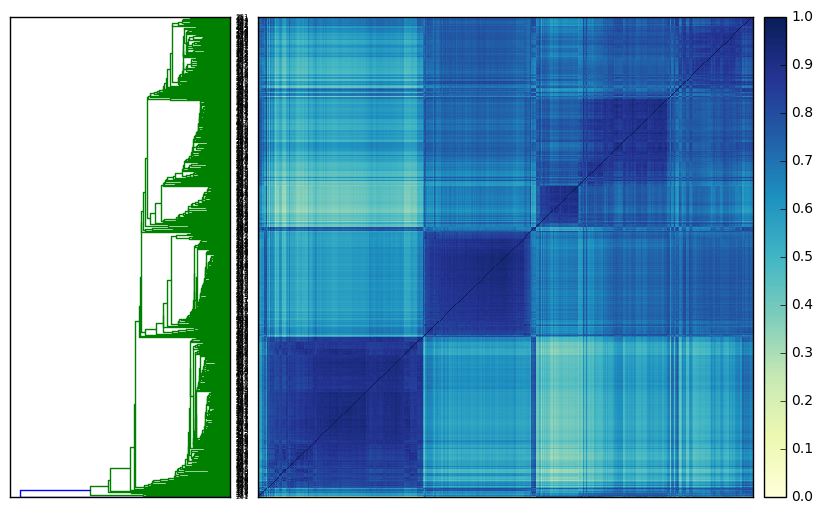

In [9]:

# note: you can adjust plots with 'vmin=0.3' or some such in the plot_composite_matrix function.
matrix, labels = fig.load_matrix_and_labels('long-contigs.matrix')
_ = fig.plot_composite_matrix(matrix, labels, show_labels=False)
pylab.savefig('tetramer.png')

## Extract clusters

In [10]:
import scipy.cluster.hierarchy as sch

In [11]:
Y = sch.linkage(matrix, method='single')

In [12]:
clusters = sch.fcluster(Y, t=0.3, criterion='distance')

In [14]:
max(clusters)

183

## Look at size distribution of bins

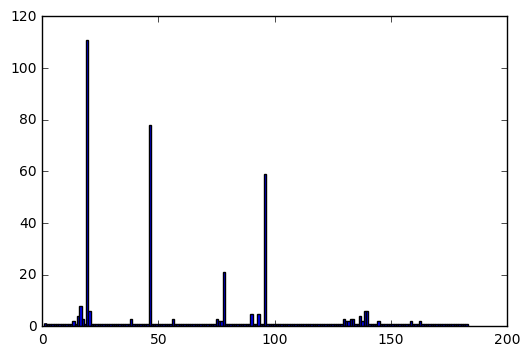

In [15]:
import pylab
n, bins, patches = pylab.hist(clusters, bins=max(clusters))

## Pick out the bins over a certain size

In [16]:
major_bins = []
MIN_SIZE=20

for bin_n, size in enumerate(n):
    if size > 20:
        major_bins.append(bin_n + 1)
        
print(major_bins)

[19, 46, 78, 96]


In [17]:
# collect members of bins
from collections import defaultdict
bin_members = defaultdict(set)

for sample_n, k in enumerate(clusters):
    if k in major_bins:
        bin_members[k].add(sample_n)

In [18]:
# sort by bin size
print([len(bin_members[k]) for k in major_bins])
bins_by_size = list(reversed(sorted([(len(bin_members[k]), k) for k in major_bins])))

[111, 78, 21, 59]


In [19]:
# extract contigs into bins
import screed

for size, bin_num in bins_by_size:
    print('extracting bin {}...'.format(bin_num))
    members = bin_members[bin_num]
    names = set([ labels[m] for m in members ])
    
    wrote = 0
    with open('cluster{}-{}.fa'.format(bin_num, len(members)), 'w') as fp:
        for record in screed.open('long-contigs.fa'):
            if record.name in names:
                fp.write('>{}\n{}\n'.format(record.name, record.sequence))
                wrote += 1
                
    print('wrote {} (should have found {}'.format(wrote, len(members)))

extracting bin 19...
wrote 111 (should have found 111
extracting bin 46...
wrote 78 (should have found 78
extracting bin 96...
wrote 59 (should have found 59
extracting bin 78...
wrote 21 (should have found 21


In [20]:
!pip install palettable

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import palettable as pal
import pandas as pd

In [22]:
t = TSNE().fit_transform(matrix)
df=pd.DataFrame(t)
df2=pd.DataFrame(clusters)
df['cluster']=df2

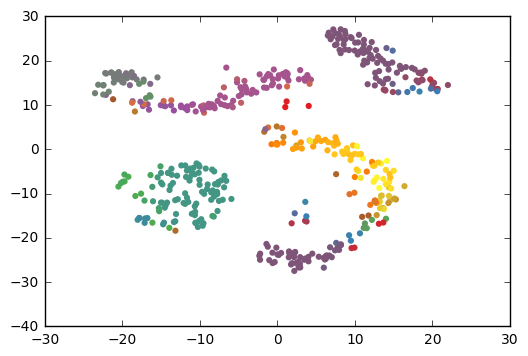

In [23]:
fig,ax=plt.subplots(1)
ax.scatter(df[0], df[1], c=df.cluster, cmap=pal.colorbrewer.qualitative.Set1_7.get_mpl_colormap(), lw=0)